In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 520

ng =8

ng_refs = (/ 3 , 2 , 3 /) 

nref =3

nv = 200

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =257

vstar = 1380

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66/

data wgt
     &     /0.55 , 0.55 , 0.85 , 0.85,
     &     0.85 , 0 , 0.3 , 0.55/

atmosphere_profiles/saw75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

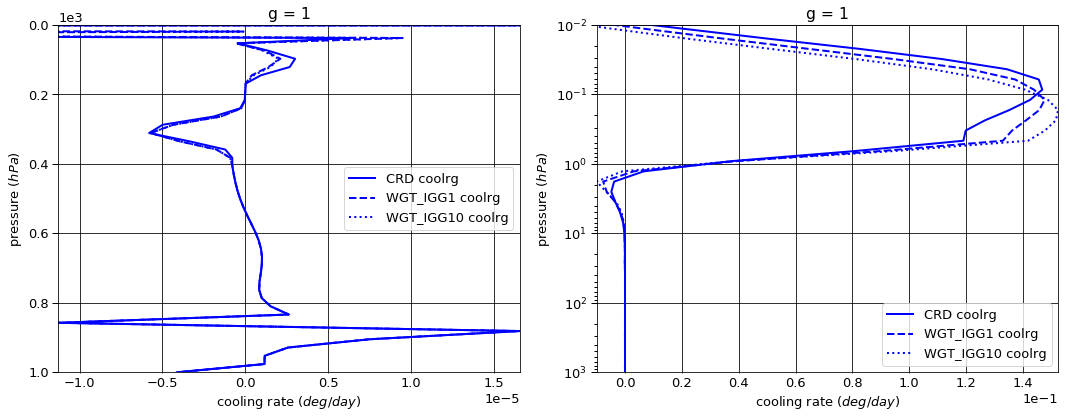

# Figure: cooling rate g-group 2

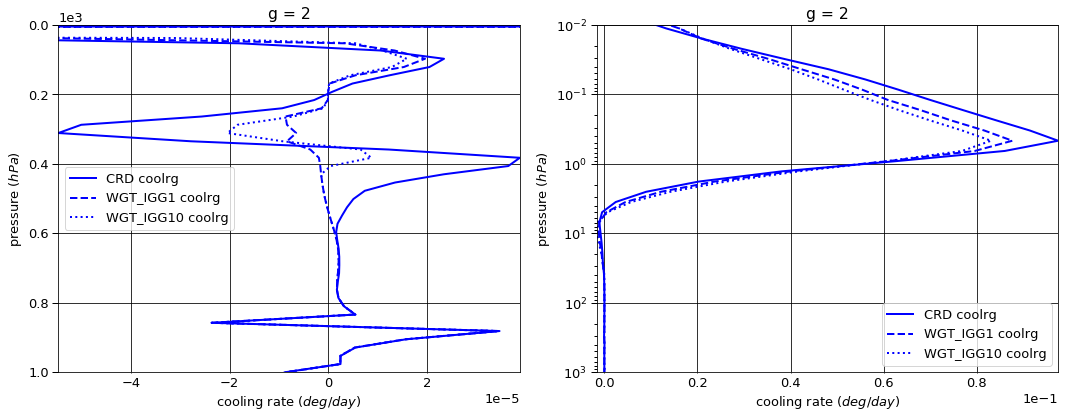

# Figure: cooling rate g-group 3

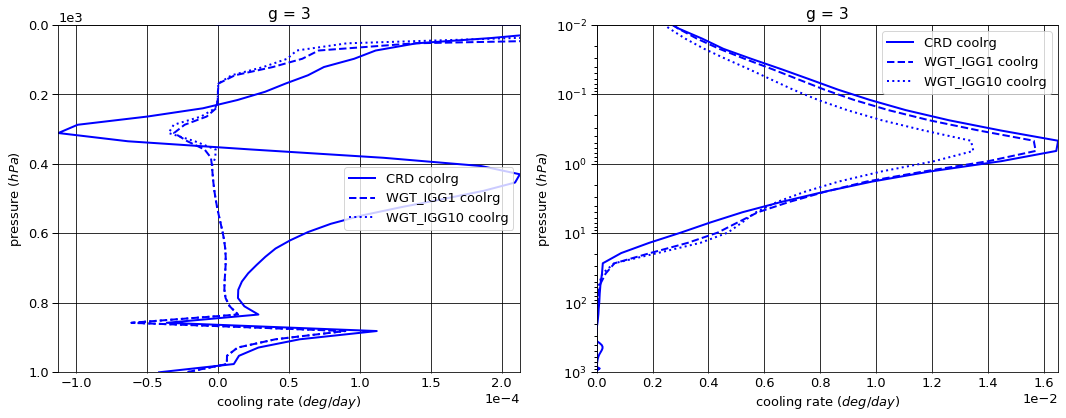

# Figure: cooling rate g-group 4

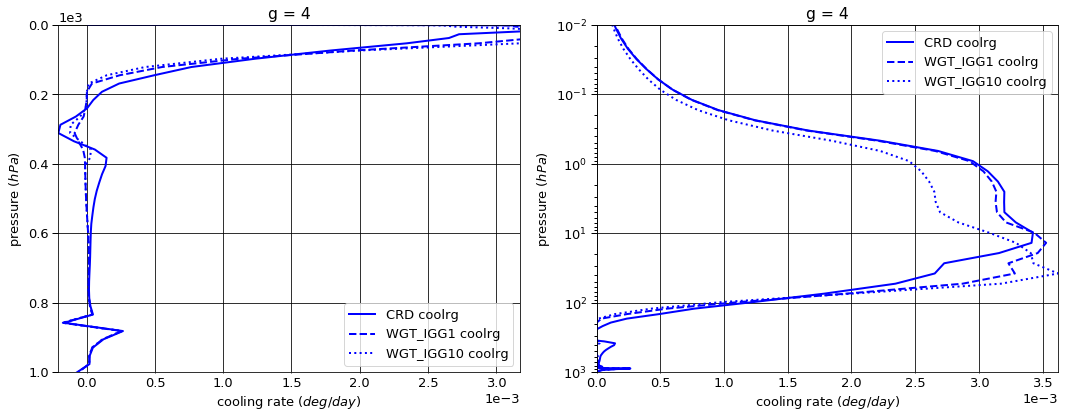

# Figure: cooling rate g-group 5

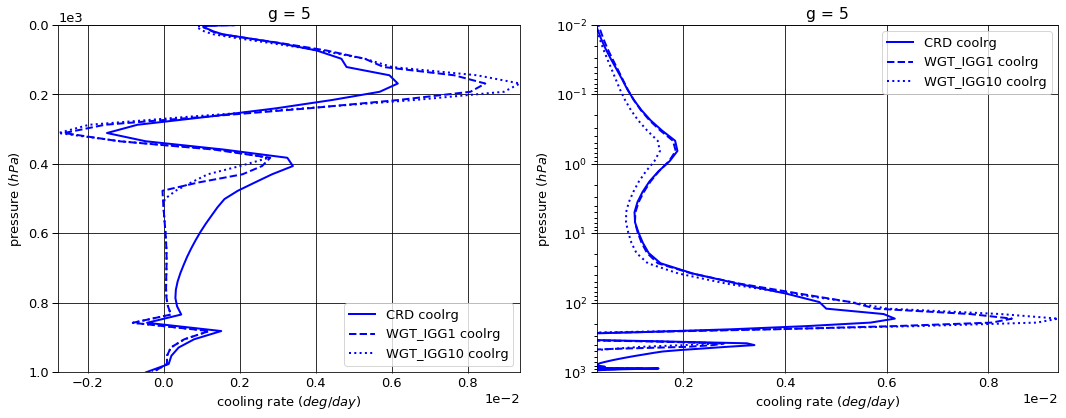

# Figure: cooling rate g-group 6

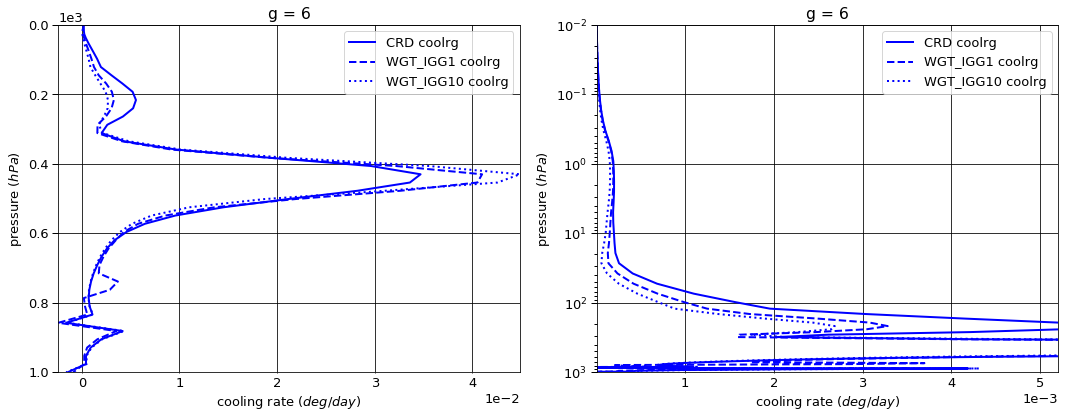

# Figure: cooling rate g-group 7

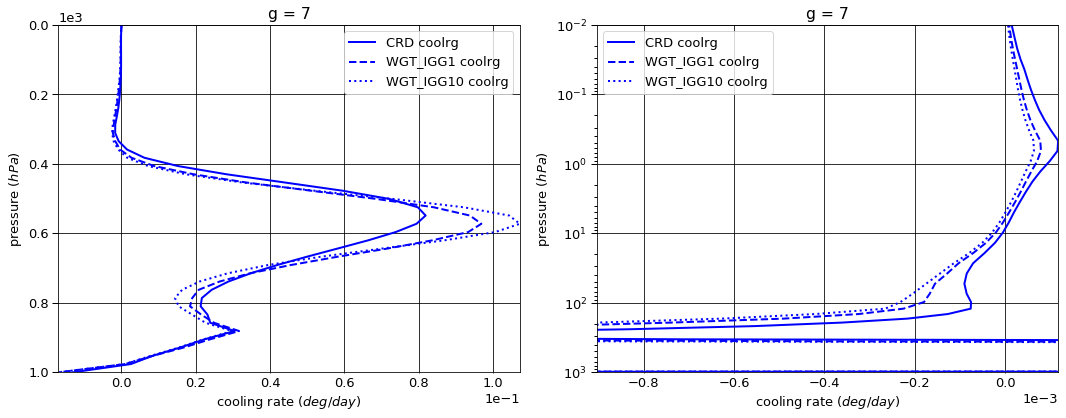

# Figure: cooling rate g-group 8

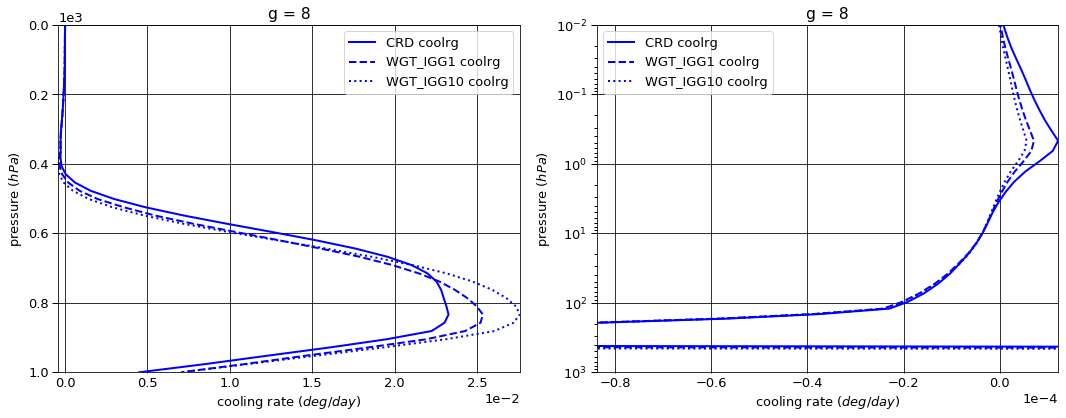

# Figure: cooling rate g-group total

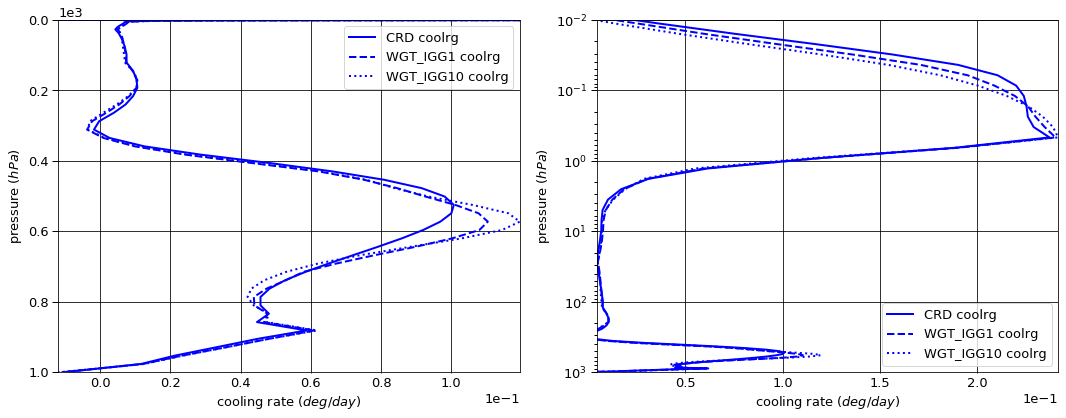

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.009644  0.000000 -0.009644
  1013.0   76    -0.012192  0.012206  0.000014
2 0.0      1     -0.012730  0.000000 -0.012730
  1013.0   76    -0.025697  0.025727  0.000030
3 0.0      1     -0.016094  0.000000 -0.016094
  1013.0   76    -0.066001  0.066161  0.000160
4 0.0      1     -0.035431  0.000000 -0.035431
  1013.0   76    -0.189890  0.190138  0.000248
5 0.0      1     -0.198886  0.000000 -0.198886
  1013.0   76    -0.881995  0.883871  0.001876
6 0.0      1     -0.764623  0.000000 -0.764623
  1013.0   76    -2.596690  2.601685  0.004996
7 0.0      1     -2.729049  0.000000 -2.729049
  1013.0   76    -5.071819  5.145567  0.073749
8 0.0      1     -1.110461  0.000000 -1.110461
  1013.0   76    -1.337157  1.223026 -0.114131


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.010067  0.000000 -0.010067
  1013.0   76    -0.012192  0.012206  0.000014
2 0.0      1     -0.012505  0.000000 -0.012505
  1013.0   76    -0.025697  0.025727  0.000029
3 0.0      1     -0.014188  0.000000 -0.014188
  1013.0   76    -0.066001  0.066077  0.000076
4 0.0      1     -0.034265  0.000000 -0.034265
  1013.0   76    -0.189890  0.190109  0.000218
5 0.0      1     -0.173855  0.000000 -0.173855
  1013.0   76    -0.881995  0.883007  0.001013
6 0.0      1     -0.780667  0.000000 -0.780667
  1013.0   76    -2.596690  2.599677  0.002987
7 0.0      1     -2.810308  0.000000 -2.810308
  1013.0   76    -5.071819  5.161390  0.089571
8 0.0      1     -1.140550  0.000000 -1.140550
  1013.0   76    -1.337157  1.207049 -0.130108


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.010283  0.000000 -0.010283
  1013.0   76    -0.012192  0.012206  0.000014
2 0.0      1     -0.012467  0.000000 -0.012467
  1013.0   76    -0.025697  0.025727  0.000029
3 0.0      1     -0.013901  0.000000 -0.013901
  1013.0   76    -0.066001  0.066077  0.000076
4 0.0      1     -0.033949  0.000000 -0.033949
  1013.0   76    -0.189890  0.190109  0.000218
5 0.0      1     -0.173841  0.000000 -0.173841
  1013.0   76    -0.881995  0.883007  0.001013
6 0.0      1     -0.769087  0.000000 -0.769087
  1013.0   76    -2.596690  2.602221  0.005532
7 0.0      1     -2.790594  0.000000 -2.790594
  1013.0   76    -5.071819  5.154164  0.082345
8 0.0      1     -1.147531  0.000000 -1.147531
  1013.0   76    -1.337157  1.250524 -0.086633


WGT_IGG1 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1     -4.228322e-04  0.000000e+00 -4.228322e-04
  1013.0   76     1.734723e-18 -1.734723e-18  0.000000e+00
2 0.0      1      2.248620e-04  0.000000e+00  2.248620e-04
  1013.0   76     0.000000e+00 -5.970000e-07 -5.965890e-07
3 0.0      1      1.906385e-03  0.000000e+00  1.906385e-03
  1013.0   76     0.000000e+00 -8.381600e-05 -8.381624e-05
4 0.0      1      1.166084e-03  0.000000e+00  1.166084e-03
  1013.0   76     0.000000e+00 -2.950000e-05 -2.949632e-05
5 0.0      1      2.503170e-02  0.000000e+00  2.503170e-02
  1013.0   76     0.000000e+00 -8.636000e-04 -8.635967e-04
6 0.0      1     -1.604338e-02  0.000000e+00 -1.604338e-02
  1013.0   76     0.000000e+00 -2.008800e-03 -2.008779e-03
7 0.0      1     -8.125910e-02  0.000000e+00 -8.125910e-02
  1013.0   76     0.000000e+00  1.582270e-02  1.582268e-02
8 0.0      1     -3.008870e-02  0.000000e+00 -3.008870e-02
  1013.0   76     0.000000e+00 -1.597740e-02 -1.597748e-02


WGT_IGG10 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1     -6.391062e-04  0.000000e+00 -6.391062e-04
  1013.0   76     1.734723e-18 -1.734723e-18  0.000000e+00
2 0.0      1      2.629590e-04  0.000000e+00  2.629590e-04
  1013.0   76     0.000000e+00 -5.970000e-07 -5.965890e-07
3 0.0      1      2.193003e-03  0.000000e+00  2.193003e-03
  1013.0   76     0.000000e+00 -8.381600e-05 -8.381624e-05
4 0.0      1      1.481772e-03  0.000000e+00  1.481772e-03
  1013.0   76     0.000000e+00 -2.950000e-05 -2.949632e-05
5 0.0      1      2.504550e-02  0.000000e+00  2.504550e-02
  1013.0   76     0.000000e+00 -8.636000e-04 -8.635967e-04
6 0.0      1     -4.463440e-03  0.000000e+00 -4.463440e-03
  1013.0   76     0.000000e+00  5.356000e-04  5.356187e-04
7 0.0      1     -6.154560e-02  0.000000e+00 -6.154560e-02
  1013.0   76     0.000000e+00  8.596900e-03  8.596898e-03
8 0.0      1     -3.707030e-02  0.000000e+00 -3.707030e-02
  1013.0   76     0.000000e+00  2.749760e-02  2.749757e-02

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.799575e-01
  1001.112500 75    -4.126409e-06
2 0.000312    1     -1.933238e-02
  1001.112500 75    -8.806777e-06
3 0.000312    1     -9.226541e-07
  1001.112500 75    -4.148073e-05
4 0.000312    1      8.341122e-06
  1001.112500 75    -7.121327e-05
5 0.000312    1     -2.078351e-05
  1001.112500 75    -4.660783e-04
6 0.000312    1      1.142245e-07
  1001.112500 75    -1.450929e-03
7 0.000312    1     -4.751998e-06
  1001.112500 75    -1.298753e-02
8 0.000312    1     -2.065360e-06
  1001.112500 75     4.496434e-03


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -1.623197e-01
  1001.112500 75    -4.126409e-06
2 0.000312    1     -1.077786e-02
  1001.112500 75    -8.643449e-06
3 0.000312    1      1.620919e-04
  1001.112500 75    -2.232853e-05
4 0.000312    1      1.651851e-05
  1001.112500 75    -6.414077e-05
5 0.000312    1      4.624976e-05
  1001.112500 75    -2.978533e-04
6 0.000312    1      1.950784e-07
  1001.112500 75    -8.785991e-04
7 0.000312    1     -3.743871e-06
  1001.112500 75    -1.679198e-02
8 0.000312    1     -1.624006e-06
  1001.112500 75     7.031779e-03


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -1.542920e-01
  1001.112500 75    -4.126409e-06
2 0.000312    1     -6.196791e-03
  1001.112500 75    -8.643449e-06
3 0.000312    1      2.506472e-04
  1001.112500 75    -2.232853e-05
4 0.000312    1      1.461646e-05
  1001.112500 75    -6.414077e-05
5 0.000312    1      3.742978e-05
  1001.112500 75    -2.978533e-04
6 0.000312    1      2.899818e-08
  1001.112500 75    -1.605244e-03
7 0.000312    1     -4.023163e-06
  1001.112500 75    -1.695933e-02
8 0.000312    1     -1.565632e-06
  1001.112500 75     7.034813e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.763780e-02
  1001.112500 75     0.000000e+00
2 0.000312    1      8.554527e-03
  1001.112500 75     1.633283e-07
3 0.000312    1      1.630146e-04
  1001.112500 75     1.915220e-05
4 0.000312    1      8.177389e-06
  1001.112500 75     7.072494e-06
5 0.000312    1      6.703326e-05
  1001.112500 75     1.682250e-04
6 0.000312    1      8.085389e-08
  1001.112500 75     5.723302e-04
7 0.000312    1      1.008126e-06
  1001.112500 75    -3.804449e-03
8 0.000312    1      4.413537e-07
  1001.112500 75     2.535346e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.566549e-02
  1001.112500 75     0.000000e+00
2 0.000312    1      1.313559e-02
  1001.112500 75     1.633283e-07
3 0.000312    1      2.515698e-04
  1001.112500 75     1.915220e-05
4 0.000312    1      6.275335e-06
  1001.112500 75     7.072494e-06
5 0.000312    1      5.821329e-05
  1001.112500 75     1.682250e-04
6 0.000312    1     -8.522636e-08
  1001.112500 75    -1.543150e-04
7 0.000312    1      7.288348e-07
  1001.112500 75    -3.971793e-03
8 0.000312    1      4.997283e-07
  1001.112500 75     2.538380e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.876918,0.000000,-4.876918
1013.0,76,-10.181441,10.148382,-0.033059



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.976403,0.000000,-4.976403
1013.0,76,-10.181441,10.145241,-0.036200



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.951653,0.000000,-4.951653
1013.0,76,-10.181441,10.184035,0.002594



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.099485,0.000000,-0.099485
1013.0,76,0.000000,-0.003141,-0.003141



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.074735,0.000000,-0.074735
1013.0,76,0.000000,0.035653,0.035653


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.199310
1001.112500,75,-0.010534



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.172878
1001.112500,75,-0.011036



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.160192
1001.112500,75,-0.011927



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.026432
1001.112500,75,-0.000502



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.039118
1001.112500,75,-0.001393


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001154,0.001196
2,0.002433,0.002525
3,0.006375,0.006475
4,0.017817,0.018636
5,0.083269,0.086563
6,0.248308,0.254744
7,0.479058,0.498801
8,0.161587,0.131059


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.262964e-18
2,2.786366e-19
3,1.821229e-20
4,1.179072e-20
5,7.724450e-22
6,2.503686e-21
7,1.649401e-22
8,1.086608e-23


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.262964e-18,NaN,0.001154,0.001196,0.001154,0.001196,1.0
2,2.786366e-19,0.065362,0.002433,0.002525,0.003587,0.003721,1.0
3,1.821229e-20,0.065362,0.006375,0.006475,0.009962,0.010196,1.0
4,1.179072e-20,0.647404,0.017817,0.018636,0.027779,0.028832,10.0
5,7.724450e-22,0.065513,0.083269,0.086563,0.111048,0.115395,10.0
6,2.503686e-21,3.241249,0.248308,0.254744,0.359356,0.370140,500.0
7,1.649401e-22,0.065879,0.479058,0.498801,0.838413,0.868941,500.0
8,1.086608e-23,0.065879,0.161587,0.131059,1.000000,1.000000,500.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     1.544046e-17  8.196443e-18   1.883800  1.037318e-03
      2 0.000312     9.182692e-19  4.329594e-19   2.120913  5.960257e-05
      3 0.000312     2.390986e-20  1.047082e-20   2.283476  1.864519e-06
      4 0.000312     3.413763e-22  2.498712e-22   1.366209  2.790310e-08
      5 0.000312     2.371223e-22  6.728620e-23   3.524085  1.802409e-08
      6 0.000312     1.255289e-24  1.207990e-24   1.039155  1.028738e-10
      7 0.000312     2.645320e-24  1.312215e-24   2.015919  1.458084e-10
      8 0.000312     1.844849e-24  1.990882e-25   9.266488  9.403975e-11
2     1 0.000750     1.543862e-17  8.239017e-18   1.873842  4.184403e-04
      2 0.000750     9.317497e-19  4.391954e-19   2.121493  2.435770e-05
      3 0.000750     2.443943e-20  1.065801e-20   2.293058  7.674067e-07
      4 0.000750     3.508129e-22  2.575034e-22   1.362362  1.155340e-08
      5 0.000750     2.397274e-22  6.809936e-23   3.520259  7.340003e-09
      6 0.000750     1.291983e-24  1.243449e-24   1.039032  4.265250e-11
      7 0.000750     2.685715e-24  1.332457e-24   2.015611  5.963140e-11
      8 0.000750     1.855717e-24  2.016272e-25   9.203699  3.812218e-11
3     1 0.001052     1.543251e-17  8.323153e-18   1.854166  5.884745e-04
      2 0.001052     9.591870e-19  4.518629e-19   2.122739  3.515902e-05
      3 0.001052     2.553552e-20  1.101980e-20   2.317239  1.123628e-06
      4 0.001052     3.682590e-22  2.710214e-22   1.358782  1.701322e-08
      5 0.001052     2.451064e-22  6.959093e-23   3.522104  1.052422e-08
      6 0.001052     1.357192e-24  1.306021e-24   1.039181  6.282524e-11
      7 0.001052     2.769857e-24  1.373542e-24   2.016580  8.622392e-11
      8 0.001052     1.879241e-24  2.066887e-25   9.092132  5.419396e-11
4     1 0.001476     1.542280e-17  8.405743e-18   1.834793  8.277138e-04
      2 0.001476     9.873161e-19  4.648729e-19   2.123841  5.076346e-05
      3 0.001476     2.670794e-20  1.139354e-20   2.344131  1.647366e-06
      4 0.001476     3.876595e-22  2.859394e-22   1.355740  2.513158e-08
      5 0.001476     2.509780e-22  7.114670e-23   3.527612  1.511690e-08
      6 0.001476     1.430338e-24  1.376228e-24   1.039317  9.287499e-11
      7 0.001476     2.861022e-24  1.417451e-24   2.018428  1.248828e-10
      8 0.001476     1.905682e-24  2.118851e-25   8.993943  7.716749e-11
5     1 0.002070     1.540956e-17  8.485577e-18   1.815971  1.163652e-03
      2 0.002070     1.015778e-18  4.780608e-19   2.124788  7.324361e-05
      3 0.002070     2.794681e-20  1.177569e-20   2.373263  2.415673e-06
      4 0.002070     4.091195e-22  3.023245e-22   1.353247  3.720844e-08
      5 0.002070     2.573241e-22  7.275770e-23   3.536727  2.173622e-08
      6 0.002070     1.512261e-24  1.454887e-24   1.039436  1.377106e-10
      7 0.002070     2.958894e-24  1.463847e-24   2.021313  1.810123e-10
      8 0.002070     1.935123e-24  2.171333e-25   8.912142  1.099903e-10
6     1 0.002904     1.539283e-17  8.562524e-18   1.797698  1.635674e-03
      2 0.002904     1.044558e-18  4.914211e-19   2.125587  1.056416e-04
      3 0.002904     2.925606e-20  1.216729e-20   2.404485  3.544115e-06
      4 0.002904     4.330283e-22  3.204729e-22   1.351217  5.525343e-08
      5 0.002904     2.641993e-22  7.443822e-23   3.549242  3.129960e-08
      6 0.002904     1.604998e-24  1.543963e-24   1.039532  2.049988e-10
      7 0.002904     3.064286e-24  1.512919e-24   2.025414  2.626716e-10
      8 0.002904     1.967973e-24  2.224260e-25   8.847765  1.570027e-10
7     1 0.004074     1.537263e-17  8.636465e-18   1.779967  2.298608e-03
      2 0.004074     1.073644e-18  5.049503e-19   2.126238  1.523046e-04
      3 0.004074     3.064037e-20  1.257080e-20   2.437424  5.202019e-06
      4 0.004074     4.598970e-22  3.407862e-22   1.349518  8.232926e-08
      5 0.004074     2.716679e-22  7.621059e-23   3.564700  4.513816e-08
      6 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
